In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [2]:
sdir='D:/SIBI/Datas'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                filepaths labels
0  D:/SIBI/Datas\A\1645707869.4431655.jpg      A
1  D:/SIBI/Datas\A\1645707871.4600735.jpg      A
2  D:/SIBI/Datas\A\1645707873.4433305.jpg      A
3   D:/SIBI/Datas\A\1645707875.362499.jpg      A
4  D:/SIBI/Datas\A\1645707878.1629865.jpg      A
labels
A    220
B    220
X    220
W    220
V    220
U    220
T    220
S    220
R    220
Q    220
P    220
O    220
N    220
M    220
L    220
K    220
I    220
H    220
G    220
F    220
E    220
D    220
C    220
Y    220
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4224   test_df length:  528   valid_df length:  528


### create train, test, valid  generators

In [4]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  66   test steps:  8
Found 4224 validated image filenames belonging to 24 classes.
Found 528 validated image filenames belonging to 24 classes.
Found 528 validated image filenames belonging to 24 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


### create function to show some image examples

In [5]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

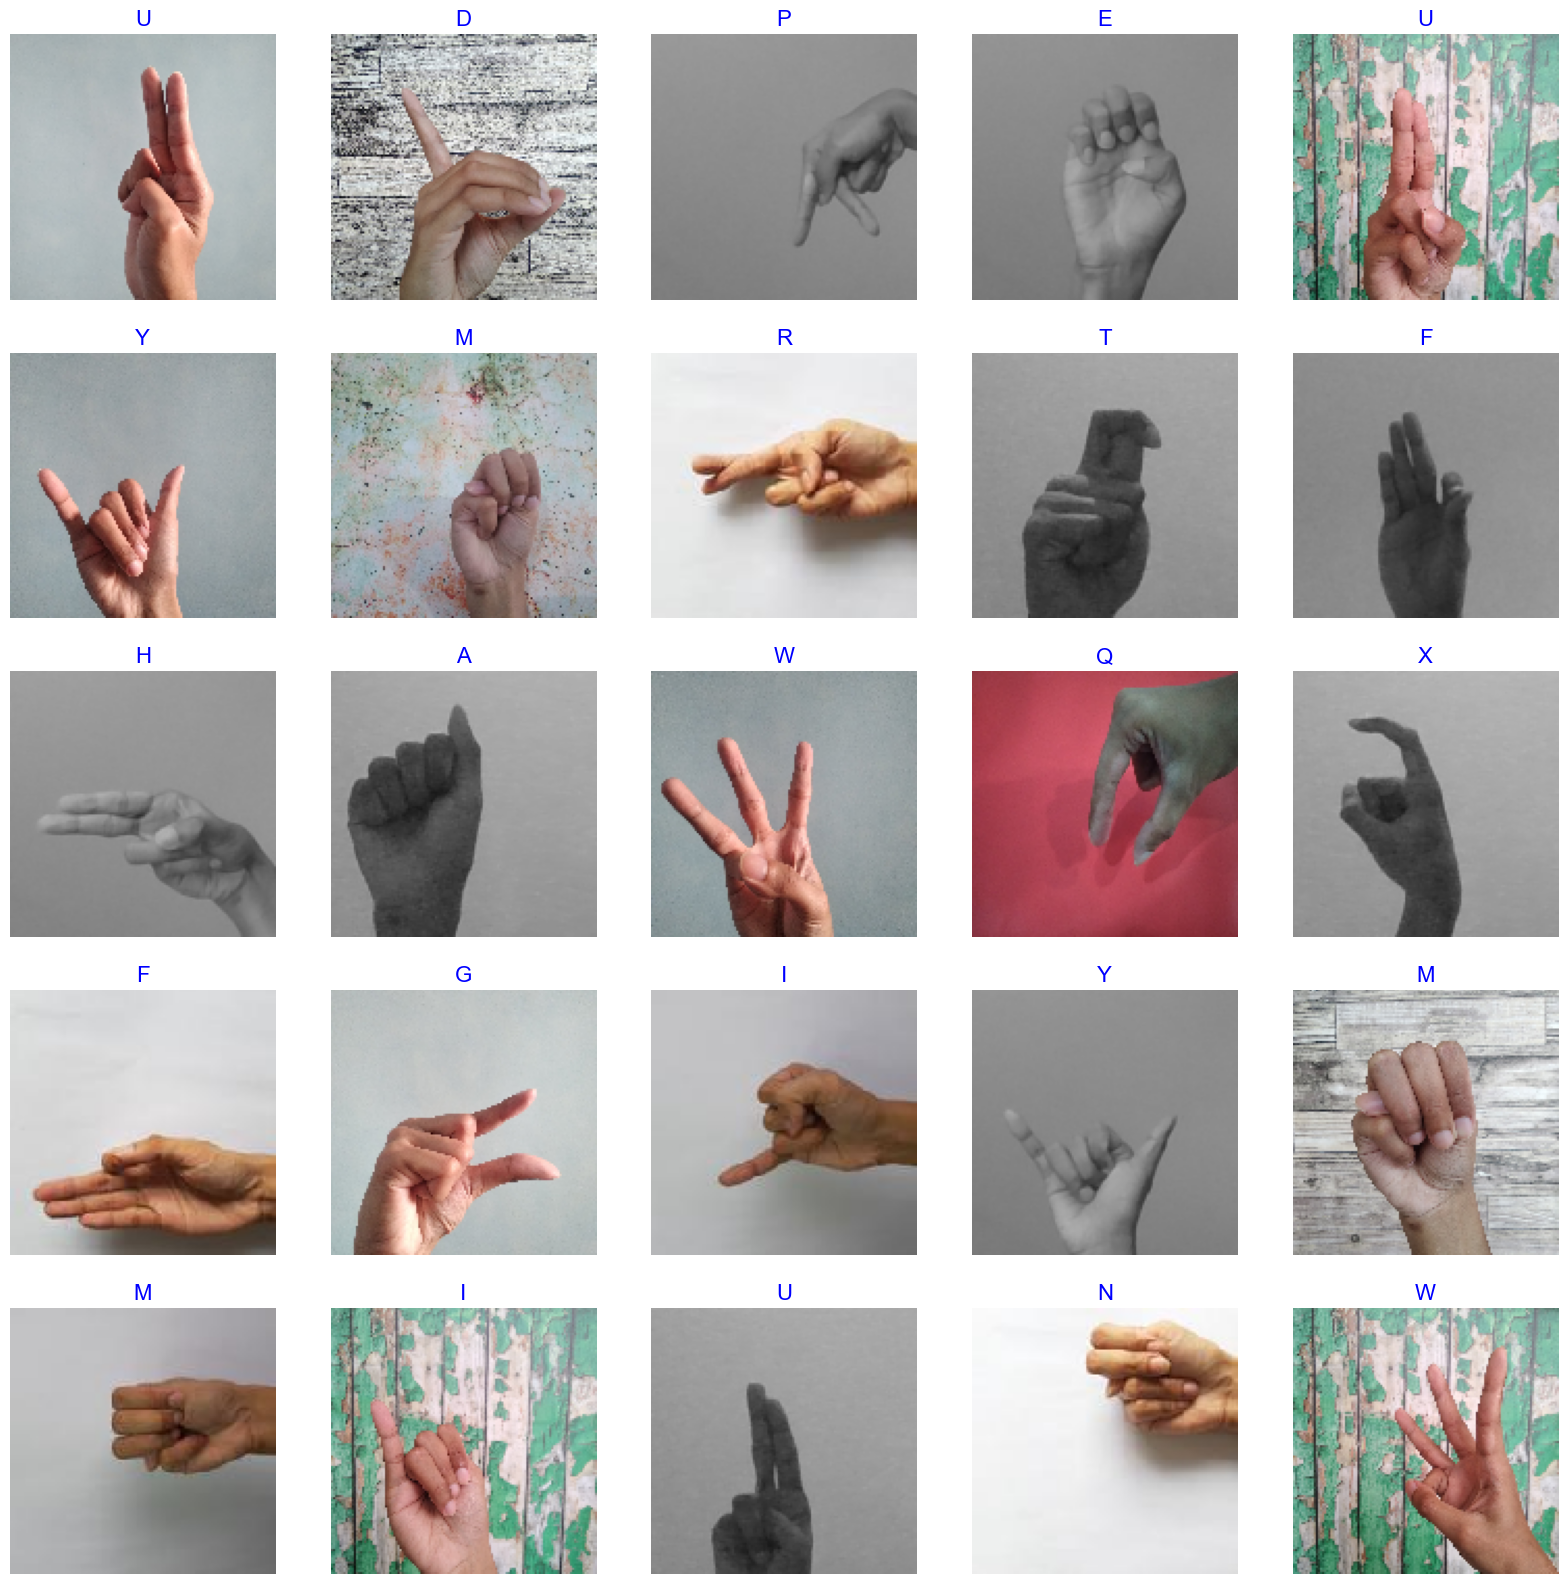

In [6]:
show_image_samples(train_gen)

### create the model

In [7]:
# Define your base model (e.g., ResNet50) with input shape
#from keras.applications import EfficientNetV2S
inputs = Input(shape=(128, 128, 3))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)




80134624/80134624 [==============================] - 15s 0us/step


In [8]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [9]:
base_model.trainable = False

In [10]:
# Add additional layers on top of the base model
x = base_model.output
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Dropout(rate=0.5)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(24, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
epochs =50

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/50


66/66 [==============================] - 286s 4s/step - loss: 3.0515 - accuracy: 0.0952 - val_loss: 2.7088 - val_accuracy: 0.2614
Epoch 2/50
66/66 [==============================] - 218s 3s/step - loss: 2.4447 - accuracy: 0.2455 - val_loss: 1.8230 - val_accuracy: 0.5133
Epoch 3/50
66/66 [==============================] - 203s 3s/step - loss: 1.8565 - accuracy: 0.3951 - val_loss: 1.3492 - val_accuracy: 0.6667
Epoch 4/50
66/66 [==============================] - 141s 2s/step - loss: 1.5668 - accuracy: 0.4735 - val_loss: 1.1363 - val_accuracy: 0.6818
Epoch 5/50
66/66 [==============================] - 139s 2s/step - loss: 1.3228 - accuracy: 0.5518 - val_loss: 0.9871 - val_accuracy: 0.7197
Epoch 6/50
66/66 [==============================] - 139s 2s/step - loss: 1.1825 - accuracy: 0.5978 - val_loss: 0.8670 - val_accuracy: 0.7462
Epoch 7/50
66/66 [==============================] - 138s 2s/step - loss: 1.0626 - accuracy: 0.6293 - val_loss: 0.7969 - val_accuracy: 0.7803
Epoch 8/50


### define function to print text in RGB foreground and background colors

In [13]:
# Save Best Model
model.save('VGG19.keras')

### define function to plot the training data

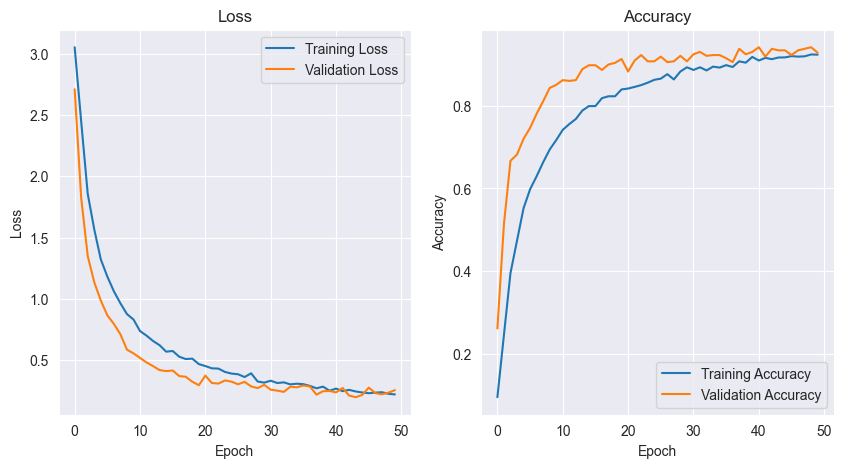

In [14]:
# Visualize Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# Accuracy on Test Set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Loss on Test Set: {test_loss,test_accuracy}')

8/8 [==============================] - 17s 2s/step - loss: 0.2038 - accuracy: 0.9470
Loss on Test Set: (0.20375771820545197, 0.9469696879386902)


8/8 [==============================] - 15s 2s/step


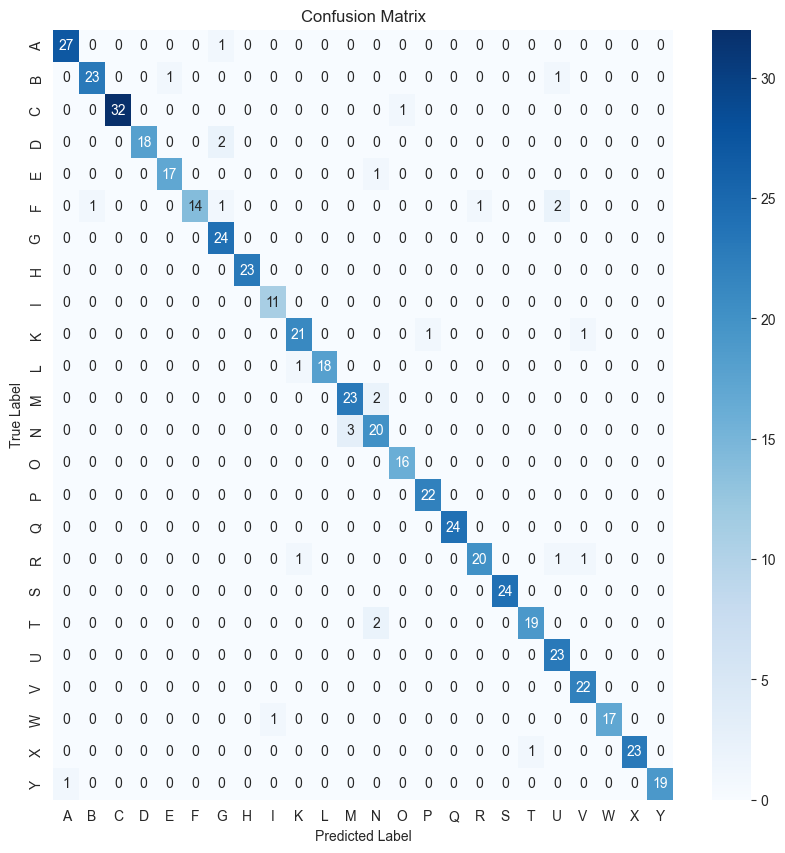

              precision    recall  f1-score   support

           A       0.96      0.96      0.96        28
           B       0.96      0.92      0.94        25
           C       1.00      0.97      0.98        33
           D       1.00      0.90      0.95        20
           E       0.94      0.94      0.94        18
           F       1.00      0.74      0.85        19
           G       0.86      1.00      0.92        24
           H       1.00      1.00      1.00        23
           I       0.92      1.00      0.96        11
           K       0.91      0.91      0.91        23
           L       1.00      0.95      0.97        19
           M       0.88      0.92      0.90        25
           N       0.80      0.87      0.83        23
           O       0.94      1.00      0.97        16
           P       0.96      1.00      0.98        22
           Q       1.00      1.00      1.00        24
           R       0.95      0.87      0.91        23
           S       1.00    

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming model and test_gen are already defined and y_pred is computed as given
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(test_gen.classes, y_pred, target_names=list(test_gen.class_indices.keys()))
print(class_report)
